What this code does
1. Runs all TSM code for the Sun
1. Adds noise to the data
1. Bins it
1. Then finds an equation for the background
1. Then finds the gaussian on that background
1. Locates V_max

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
import math
from statistics import stdev 

## Bin_it
This function bins one array and reduces another array to match its length so they can be plotted together. This is done to reduce the noise whihc comes from the noise on the data.
###  Inputs
- yvalues: y array, the Power normally called Fulldata in this code
- xvalues: x array, the frequency
- binsize: the size of the bin the y values will be averaged in, every binsizeth value will also be taken from the x array<br>
### Outputs
- Binned y array (Power)
- reduced x array (Frequency)

In [2]:
def bin_it(yvalues, xvalues, binsize):
    '''puts an array into averaged bins of a given size'''
    N=int(math.ceil(len(yvalues)/binsize))
    C=0
    newy=[]
    while C<N:
        if (C+1)*binsize<len(yvalues):
            Q=(np.sum(yvalues[C*binsize:(C+1)*binsize]))/binsize
        else:
            Q=(np.sum(yvalues[C*binsize:len(yvalues)]))/binsize
        newy.append(Q)
        C+=1
    y=np.array(newy)
    x=xvalues[0::binsize] 
    return y[0:len(y)-1], x[0:len(y)-1]

## addnoise
adds noise to and array. The method used to generate the noise was taken from a recommended scientific paper
### Input
- pure: orignal array
### output
- array with noise added

In [3]:
#Adds random noise
def addnoise(pure):
    vary = np.random.uniform(0, 1, pure.shape)
    signal = -(pure* np.log(vary))
    return signal

## gausgran
Is the equation of a gaussian where the base is not just a flat line, it is adjusted by an array fitted to the background called fittedgran.
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a gaussian on a line fitted to the background of the data

In [4]:
def gausgran(x, height, centre, width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran

## gaus
The equation of a gaussian. 
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a gaussian

In [5]:
def gaus(x, height, centre, width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))

## findgran
Finds an equation which describes the background noise of the initial data and returns the values needed to plot the background
### Inputs
- x: x value array (frequency) 
- y: y value arrat (power)
### Output
- best_vals is an array of to integers which can be put into graneq to fit the background noise

In [6]:
def findgran(x, y):
    #guess_vals=[np.max(y),y[round(len(y)/4)]]
    guess_vals=[0, 0]
    best_vals, covar =curve_fit(graneq, x, y, p0=guess_vals)
    return best_vals

## graneq
plots returns the y values of the background if the x array and two constants are inserted
### Inputs
- x: x array (frequency)
- A: constant calulated by findgran
- tau: constant calulated by findgran
### Output
- array of y values of the background

In [7]:
def graneq(x,A,tau,SN):
    '''equation to describe the background'''
    return A/(1+(2*np.pi*x*tau)**2)+SN

## find_nearest
finds the value in an array closest to a given number and returns the values index in the array
### Inputs
- array: array containing the values you want to test
- value: value which you want to find the nearest value of in the array
### Output
- index of the value in the array which is closest to the given number

In [8]:
def find_nearest(array, value):
    '''finds value closest to a given value in an array'''
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

Bellow are the equations for a straight line and an exponential line. Will be used for fitting a line of best fit for the final results

In [15]:
def f(x,a,b):
    return a*x+b
def f1(x,a,b,c):
    return a*np.exp(b*x)+c

Imports data

In [9]:
#data = np.genfromtxt('Kypoints.txt', delimiter=' ')
#extradata = np.genfromtxt('Kotherstuff.txt', delimiter=' ')
data = np.genfromtxt('Kypoints (1).txt', delimiter=' ')
extradata = np.genfromtxt('Kotherstuff (1).txt', delimiter=' ') 
extradata = np.delete(extradata, (0), axis=0) #removes title row

## vmaxplot
Finds the vmax of a given number of stars. Returns a subplot showing the steps taken by the code.
### Inputs
- powerdata: The y values of a given star
- truevmax: The true vmax of a given star provided by TSM
- truevmag: The true vmag of a given star provided by TSM
- N: The number of trials for each star
- binsize: The bin size used in the binning step of the code
- Starnumber: The number of the star being tested used for the titles of graphs
- Want_subplot: If the code should return the subplots 'yes' subplots are wanted anything else will not return subplots
### Output
- difference: Returns the differnce between the truevmax and the fitted vmax for a given star

In [10]:
def vmaxplot(powerdata,truevmax,truevmag,N,binsize,Starnumber,Want_subplot):
    frequency=data[0]
    C=0
    fails=0
    amps=[]
    centres=[]
    widths=[]
    while C<N:
        y,x=bin_it(addnoise(powerdata),frequency,binsize) #adds noise and bins
        SN = 18*10**(-0.4*(11.0-truevmag)) #Calculates SN
        bv,covar =curve_fit(graneq,x,y,p0=[0,0,SN],bounds=([0,0,SN-SN/100],[np.inf,np.inf,SN+SN/100])) 
        #finds equation for background
        background=graneq(x,bv[0],bv[1],bv[2])
        fittedgran=background
        yflat=y-fittedgran #subtracts the background from the data
        p0=[0.05,6000,350] #initial guesses for gaussian
        try:
            best_vals, covar = curve_fit(gaus,x,yflat,p0=p0,bounds=([0.0,3000,300],[np.inf,14000,np.inf])) #fits gaussian
            amps.append(best_vals[0])
            centres.append(best_vals[1])
            widths.append(best_vals[2])
            C+=1
        except:
            fails+=1
            C+=1
    if len(centres)>0:
        average_v_max=np.mean(centres)
        difference=np.abs(average_v_max-truevmax)
        #print(difference)
        if Want_subplot=='yes':
            print(f'{fails}/{N} trails failed')
            print(f'average v_max {average_v_max} which is {difference} away from the true value of {truevmax}')
            #Code bellow plots sub plots tracking process of the analysis
            fig, axs  = plt.subplots(3, 2,figsize=(12,12))
            fig.suptitle(f'Star {int(Starnumber)} vmag: {truevmag}', fontsize=20)
            axs[0,0].plot(frequency, powerdata, label='data')
            axs[0,0].set_title('Data provided by TSM')
            axs[0,0].set_xlabel('Frequency')
            axs[0,0].set_ylabel('Power')
            axs[0,0].legend()
            axs[0,1].plot(frequency, addnoise(powerdata), label='data')
            axs[0,1].set_title('Noise added')
            axs[0,1].set_xlabel('Frequency')
            axs[0,1].set_ylabel('Power')
            axs[0,1].legend()
            axs[1,0].plot(x, y, label='data')
            axs[1,0].plot(x, background, label='Fitted background')
            axs[1,0].axvline(truevmax, color='yellow', label='True vmax')
            axs[1,0].set_title(f'Binned binsize: {binsize} background fitted')
            axs[1,0].set_xlabel('Frequency')
            axs[1,0].set_ylabel('Power')
            axs[1,0].legend()
            axs[1,1].plot(x, yflat, label='data')
            axs[1,1].axhline(0, color='black')
            axs[1,1].set_title('Background subtracted from data')
            axs[1,1].set_xlabel('Frequency')
            axs[1,1].set_ylabel('Power')
            axs[1,1].legend()
            axs[2,0].plot(x, yflat, label='data')
            axs[2,0].plot(x, gaus(x, np.mean(amps), np.mean(centres), np.mean(widths)), label='Fitted gaussian')
            axs[2,0].axvline(truevmax,color='yellow', label='True vmax')
            axs[2,0].axvline(average_v_max, color='purple', label='Fitted vmax')
            axs[2,0].set_title('Fitted gaussian')
            axs[2,0].set_xlabel('Frequency')
            axs[2,0].set_ylabel('Power')
            axs[2,0].legend()
            bottom=find_nearest(x, truevmax-2500)
            top=find_nearest(x, truevmax+2500)
            xf=x[bottom:top]
            yflatf=yflat[bottom:top]#crops data down
            axs[2,1].plot(xf, yflatf,label='data')
            axs[2,1].plot(xf, gaus(xf, np.mean(amps), np.mean(centres), np.mean(widths)), label='Fitted gaussian')
            axs[2,1].axvline(truevmax, color='yellow', label='True vmax')
            axs[2,1].axvline(average_v_max, color='purple', label='Fitted vmax')
            axs[2,1].set_title('Cropped fitted gaussian')
            axs[2,1].set_xlabel('Frequency')
            axs[2,1].set_ylabel('Power')
            axs[2,1].legend()
            plt.subplots_adjust(top=0.95, hspace=0.3)
            plt.show()
            print('-----------------------------------------------------------------------------------------------------------')
        return difference
    else:
        print('fails')
        plt.plot(x, y, label='data')
        plt.plot(x, background, label='background')
        plt.legend()
        plt.show()

How many stars do you wantto analyse? pick an integer no larger than 50: 10
Do you want subplots? (yes or no): no
10/10 stars run


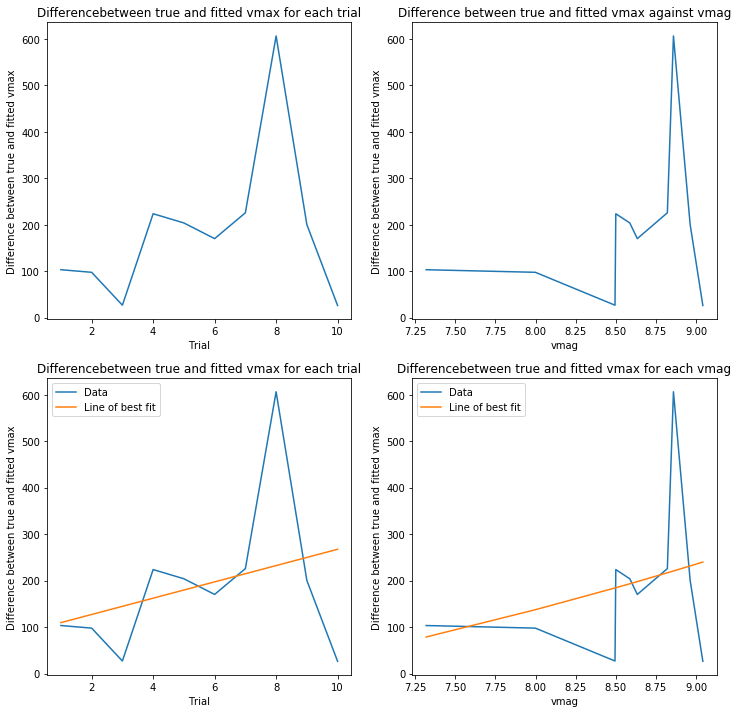

Equation of line of best fit for trail against difference: 17.54880985768264*x+92.02093147307542

Equation of line of best fit for vmag against difference: 184.62239953815865*e^(0.14922088147179313*x)-471.6668065858432


In [25]:
Number_of_star=input(f'How many stars do you wantto analyse? pick an integer no larger than {len(extradata[:,0])}: ')
Want_subplot=input('Do you want subplots? (yes or no): ')
differences=[]
m=np.linspace(1,int(Number_of_star),int(Number_of_star))
binsize=6000
number_of_trails=100
for n in m:
    differences.append(vmaxplot(data[int(n)], extradata[int(n)-1,1], extradata[int(n)-1,2], number_of_trails,binsize,n,Want_subplot))
    if n % 10 == 0:
        print(f'{int(n)}/{int(Number_of_star)} stars run')
if len(differences)>0:
    fig, axs  = plt.subplots(2, 2,figsize=(12,12))
    axs[0,0].plot(m, differences)
    axs[0,0].set_xlabel('Trial')
    axs[0,0].set_ylabel('Difference between true and fitted vmax')
    axs[0,0].set_title('Differencebetween true and fitted vmax for each trial')
    vmags=extradata[:,2]
    vmags=vmags[0:int(Number_of_star)]
    axs[0,1].plot(vmags,differences)
    axs[0,1].set_xlabel('vmag')
    axs[0,1].set_ylabel('Difference between true and fitted vmax')
    axs[0,1].set_title('Difference between true and fitted vmax against vmag')
    bvs, covar = curve_fit(f,m,differences,p0=[1,50])
    axs[1,0].plot(m,differences,label='Data')
    axs[1,0].plot(m,f(m,bvs[0],bvs[1]),label='Line of best fit')
    axs[1,0].set_xlabel('Trial')
    axs[1,0].set_ylabel('Difference between true and fitted vmax')
    axs[1,0].set_title('Differencebetween true and fitted vmax for each trial')
    axs[1,0].legend()
    try:
        bvs1, covar = curve_fit(f1,vmags,differences,p0=[1,1,150])
    except:
        bvs1, covar = curve_fit(f,vmags,differences,p0=[1,150])
    axs[1,1].plot(vmags,differences,label='Data')
    if len(bvs1)>2:
        axs[1,1].plot(vmags,f1(vmags,bvs1[0],bvs1[1],bvs1[2]),label='Line of best fit')
    else:
        axs[1,1].plot(vmags,f(vmags,bvs1[0],bvs1[1]),label='Line of best fit')
    axs[1,1].set_xlabel('vmag')
    axs[1,1].set_ylabel('Difference between true and fitted vmax')
    axs[1,1].set_title('Differencebetween true and fitted vmax for each vmag')
    axs[1,1].legend()
    plt.show()
    print(f'Equation of line of best fit for trail against difference: {bvs[0]}*x+{bvs[1]}')
    print('')
    if len(bvs1)>2:
        print(f'Equation of line of best fit for vmag against difference: {bvs1[0]}*e^({bvs1[1]}*x){bvs1[2]}')
    else:
        print(f'Equation of line of best fit for vmag against difference: {bvs1[0]}*x{bvs1[1]}')